# California Recall Simulation

In [60]:
from pref_voting.voting_methods import *
from pref_voting.generate_spatial_profiles import *
from pref_voting.analysis import estimated_std_error, binomial_confidence_interval
from pref_voting.spatial_profiles import linear_utility

import numpy as np
import pandas as pd

from multiprocess import Pool, cpu_count

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import gc

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [81]:
csv_data = 'ca_recall_sim_num_prob_samples_10/data_sim_v3'

manipulation_level = 1.0
recall_decision_type = 'sincere' #'strategic'
replacement_rule = 'sincere' #'strategic-top-two'

filename = f'sim_diff_probs_{recall_decision_type}_{replacement_rule}_{manipulation_level}.pdf'
title = f'Multiple Probabilities: recall decision type: {recall_decision_type}, replacement rule: {replacement_rule}, manipulation level: {manipulation_level}'


dfs = []
for file in glob.glob(f"./{csv_data}/*.csv"):
    df = pd.read_csv(file)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
# remove duplicate rows
df = df.drop_duplicates()

x_labels = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

df=df[df['concentration_parameter'].isin(x_labels)]
df=df[df['recall_decision_type'] == recall_decision_type]
df=df[df['replacement_rule'] == replacement_rule]
df=df[df['manipulation_level'] == manipulation_level]

df.to_csv(f"./{csv_data}.csv", index=False)

df['conditional_probability'] = df['pr_incumbent_maj_pref_winner_after_recall'] / df['pr_recall']


df['conditional_prob_diff'] = df['conditional_probability'] - df['conditional_pr_incumbent_maj_pref_winner_after_recall']

print(df[df['concentration_parameter']==100000]['pr_incumbent_maj_pref_winner'])

print(df[df['concentration_parameter']==100000]['pr_recall'])


df['pr_incumbent_maj_pref_winner']

19    0.459311
Name: pr_incumbent_maj_pref_winner, dtype: float64
19    0.542149
Name: pr_recall, dtype: float64


4     0.459148
13    0.462019
16    0.455771
17    0.459869
19    0.459311
23    0.458862
24    0.457162
Name: pr_incumbent_maj_pref_winner, dtype: float64

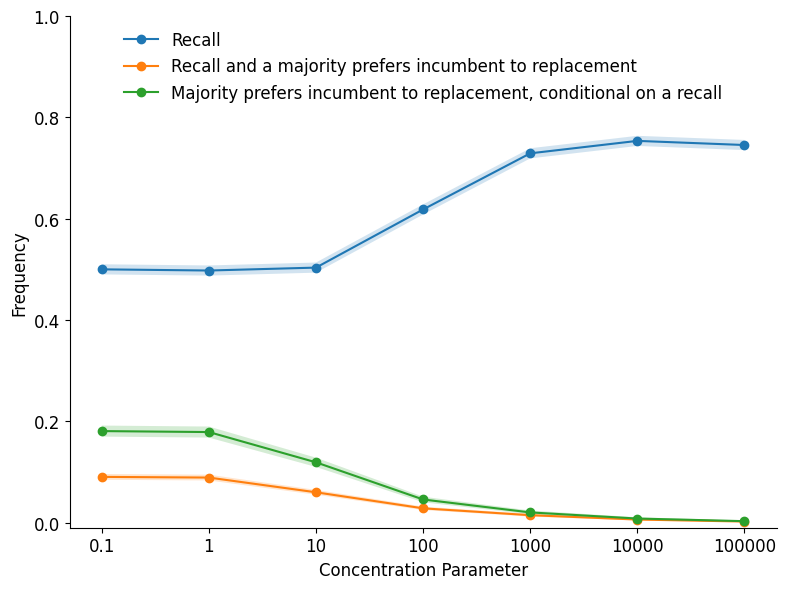

In [71]:

# csvfile_path = f"./{csv_data}.csv"

# df = pd.read_csv(csvfile_path)

# Define x-axis labels in the correct order
x_labels = sorted(df['concentration_parameter'])

# Function to plot specified y-values with error bars on the same graph
def plot_with_error(df, x_labels, y_columns, error_columns, filename):

    fontsize = 12
    # Filter and sort the data to match x_labels order
    df_sorted = df[df['concentration_parameter'].isin(x_labels)].copy()
    df_sorted['x_order'] = df_sorted['concentration_parameter'].apply(lambda x: x_labels.index(x))
    df_sorted = df_sorted.sort_values('x_order')

    # Create numerical indices for x-axis
    x_values = np.arange(len(x_labels))

    # Plotting setup
    plt.figure(figsize=(8, 6))

    # Iterate over each y-value and error column to plot them
    for y_column, error_column in zip(y_columns, error_columns):
        # Extract relevant y-values and error values
        pr_values = df_sorted[y_column].values


        # Convert to numeric and ensure finite values
        pr_values = np.nan_to_num(pd.to_numeric(pr_values, errors='coerce'), nan=0.0, posinf=0.0, neginf=0.0)

        # Plot the data with shaded error regions
        plt.plot(x_values, pr_values, marker='o', label="Recall" if y_column == 'pr_recall' else ("Majority prefers incumbent to replacement, conditional on a recall" if y_column == "conditional_pr_incumbent_maj_pref_winner_after_recall" else "Recall and a majority prefers incumbent to replacement"))

        if error_column != "":
            error_values = df_sorted[error_column].values
            error_values = np.nan_to_num(pd.to_numeric(error_values, errors='coerce'), nan=0.0, posinf=0.0, neginf=0.0)
            plt.fill_between(x_values, pr_values - error_values, pr_values + error_values, alpha=0.2)

    # Formatting the plot
    # Convert x_labels to remove trailing .0 if present
    formatted_labels = [str(int(label)) if label == int(label) else str(label) for label in x_labels]
    plt.xticks(x_values, formatted_labels, rotation=0, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('Concentration Parameter', fontsize=fontsize)
    plt.ylabel('Frequency', fontsize=fontsize)
    plt.ylim(-0.01, 1)
    plt.title('') #f'{title}')


    plt.legend(frameon=False, loc='upper center', fontsize=fontsize)#, bbox_to_anchor=(0.15, 1))   
    sns.despine()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"{filename}")
    # Display the plot
    plt.show()

# Specify the column names for y-values and errors
y_columns = [
    "pr_recall", 
    "pr_incumbent_maj_pref_winner_after_recall", 
    "conditional_pr_incumbent_maj_pref_winner_after_recall"
    ]
error_columns = [
    "err_recall_events", 
    "err_incumbent_maj_pref_winner_after_recall_events", 
    "err_conditional_pr_incumbent_maj_pref_winner_after_recall"
    ]

# Call the plotting function
plot_with_error(df, x_labels, y_columns, error_columns, filename)


## Sample Polarized Election

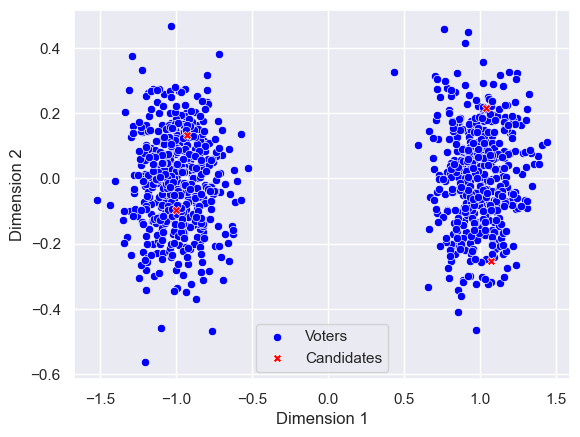

In [94]:
num_dims = 2

num_cands_incumbent_party = 2
num_cands_opposition_party = 2

pr_incumbent_party_voters = 0.5
concentration_param_for_num_voters = 100

num_voters = 1000

# Generate candidate clusters
cand_clusters = [
    ((-1, 0), generate_covariance(num_dims, 0.15, 0), num_cands_incumbent_party),  # Incumbent party
    ((1, 0), generate_covariance(num_dims, 0.15, 0), num_cands_opposition_party),  # Opposition party
]

# Generate voter clusters
v_size_incumbent, v_size_opposition = np.random.dirichlet([
    pr_incumbent_party_voters * concentration_param_for_num_voters, 
    (1 - pr_incumbent_party_voters) * concentration_param_for_num_voters
])

voter_clusters = [
    ((-1, 0), generate_covariance(num_dims, 0.15, 0), int(num_voters * v_size_incumbent)),  # Incumbent voters
    ((1, 0), generate_covariance(num_dims, 0.15, 0), int(num_voters * v_size_opposition)),  # Opposition voters
]

# Generate spatial and utility profiles
sprof = generate_spatial_profile_polarized(cand_clusters, voter_clusters, cluster_types = ["incumbent party", "opposition party"])

sprof.view()

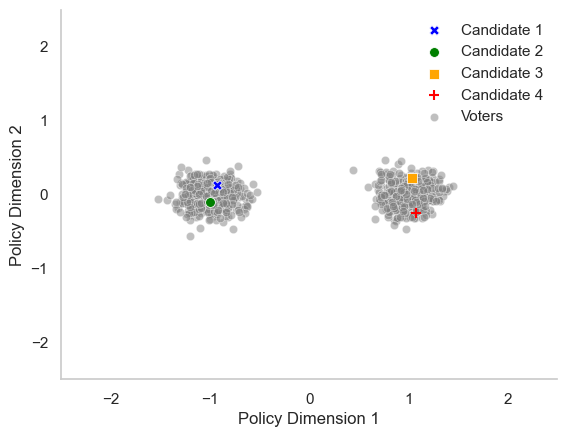

In [97]:
# white background

sns.set_style("whitegrid")
sprof_to_display = sprof
# Scatter plots
sns.scatterplot(
    x=[sprof_to_display.voter_position(v)[0] for v in sprof_to_display.voters], 
    y=[sprof_to_display.voter_position(v)[1] for v in sprof_to_display.voters], 
    color="gray", alpha=0.5, label="Voters"
)

cand = 0
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="blue", marker='X', s=50, label="Candidate 1"
)

cand = 1
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="green", marker='o', s=50, label="Candidate 2"
)

cand = 2
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="red", marker='+', linewidth=1.5, s=50, label="Candidate 4"
)

cand = 3
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="orange", marker='s', label="Candidate 3", s=50
)

# Set labels for axes
plt.xlabel('Policy Dimension 1')
plt.ylabel('Policy Dimension 2')

# Retrieve and reorder legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 4, 3, 0]  # Example order: "Candidate 1", "Candidate 2", "Candidate 4", "Candidate 3", "Voters"

# Apply reordered legend
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False)

plt.ylim(-2.5, 2.5)
plt.xlim(-2.5, 2.5)
plt.grid(False)
sns.despine()

# Save and show the plot
plt.savefig("polarized_spatial_profile_3.pdf", bbox_inches='tight')
plt.show()
